# Imports & basic configuration

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Fri Apr 21 18:44:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    On   | 00000000:21:00.0  On |                  Off |
| 41%   40C    P8    20W / 140W |   1066MiB / 16376MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# 1-dimensional PDE

## Allen-Cahn
$$
\partial_t u(t,x) + \frac{1}{2} \Delta u(t,x) + u(t,x) - u^3(t,x) = 0,
$$
admits the traveling wave solution
$$u(t,x) = -\frac{1}{2} - \frac{1}{2}
\tanh \left( \frac{3}{4} (T-t) - \sum\limits_{i=1}^d \frac{x_i}{2\sqrt{d}} \right),
\qquad
(t,x) \in [0,T]\times \mathbb{R}^d.
$$

In [5]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-x[0]/2 + 3*(T-t)/4)

t_lo, x_lo, x_hi = 0., -8., 8.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 42 seconds; L1 error: 6.19E-04; L2 error: 5.54E-07; rel error: 5.85E-02.
fdb runtime: 0 seconds; total runtime: 42 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 74 seconds; L1 error: 2.36E-03; L2 error: 7.05E-06; rel error: 5.09E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.78E-03; L2 error: 4.43E-06; rel error: 3.74E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 5.70E-04; L2 error: 4.68E-07; rel error: 1.25E-01.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 75 seconds; L1 error: 5.88E-04; L2 error: 5.51E-07; rel error: 2.44E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.48E-03; L2 error: 2.93E-06; rel error: 2.74E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 7.20E-04; L2 error: 7.60E-07; rel error: 1.40E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 59 seconds; L1 error: 5.73E-04; L2 error: 5.59E-07; rel error: 2.46E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 79 seconds; L1 error: 5.06E-03; L2 error: 3.83E-05; rel error: 3.62E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 4.34E-04; L2 error: 2.60E-07; rel error: 1.00E-01.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 78 seconds; L1 error: 1.83E-03; L2 error: 4.31E-06; rel error: 3.66E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 85 seconds; L1 error: 2.22E-03; L2 error: 7.23E-06; rel error: 2.52E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 6.66E-04; L2 error: 7.22E-07; rel error: 7.20E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 70 seconds; L1 error: 6.63E-04; L2 error: 6.34E-07; rel error: 4.48E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 1.68E-03; L2 error: 4.51E-06; rel error: 6.71E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 6.10E-04; L2 error: 6.50E-07; rel error: 1.24E-01.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 67 seconds; L1 error: 5.07E-04; L2 error: 4.27E-07; rel error: 6.36E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 1.58E-03; L2 error: 4.34E-06; rel error: 5.01E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 6.58E-04; L2 error: 7.09E-07; rel error: 8.13E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 61 seconds; L1 error: 1.10E-03; L2 error: 1.94E-06; rel error: 4.16E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 2.86E-03; L2 error: 1.16E-05; rel error: 4.78E-01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 6.75E-04; L2 error: 7.60E-07; rel error: 3.26E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 72 seconds; L1 error: 1.33E-02; L2 error: 1.99E-04; rel error: 3.21E+00.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 2.42E-03; L2 error: 7.96E-06; rel error: 3.38E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 6.24E-04; L2 error: 5.67E-07; rel error: 1.02E-01.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 59 seconds; L1 error: 6.88E-04; L2 error: 6.27E-07; rel error: 1.23E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.56E-03; L2 error: 3.29E-06; rel error: 4.46E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 5.03E-04; L2 error: 4.25E-07; rel error: 1.36E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 78 seconds; L1 error: 5.40E-04; L2 error: 3.98E-07; rel error: 5.65E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 86 seconds; L1 error: 3.13E-03; L2 error: 1.52E-05; rel error: 3.77E-01.




######## Summary for deep branching method
runtime:        38
fdb runtime:    0
total runtime:  38
mean L1 error:  6.08E-04
std L1 error:   8.12E-05
mean L2 error:  5.87E-07
std L2 error:   1.57E-07
mean rel error: 9.71E-02
std rel error:  3.38E-02


######## Summary for deep galerkin method
runtime:        69
mean L1 error:  2.21E-03
std L1 error:   3.73E-03
mean L2 error:  2.15E-05
std L2 error:   5.91E-05
mean rel error: 5.27E-01
std rel error:  9.06E-01


######## Summary for deep BSDE method
runtime:        86
mean L1 error:  2.38E-03
std L1 error

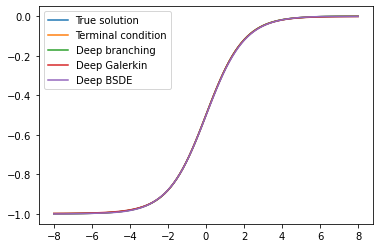

In [6]:
T = .001
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 7.60E-04; L2 error: 8.57E-07; rel error: 4.59E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 66 seconds; L1 error: 6.09E-04; L2 error: 5.59E-07; rel error: 8.69E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 2.30E-03; L2 error: 7.69E-06; rel error: 4.11E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 7.10E-04; L2 error: 7.60E-07; rel error: 6.81E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 71 seconds; L1 error: 6.14E-03; L2 error: 4.33E-05; rel error: 9.58E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 85 seconds; L1 error: 2.09E-03; L2 error: 5.86E-06; rel error: 1.85E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 7.02E-04; L2 error: 7.25E-07; rel error: 9.71E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 77 seconds; L1 error: 9.33E-04; L2 error: 1.21E-06; rel error: 7.81E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 4.65E-03; L2 error: 3.33E-05; rel error: 4.84E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 4.04E-04; L2 error: 2.79E-07; rel error: 3.33E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 78 seconds; L1 error: 1.79E-03; L2 error: 3.90E-06; rel error: 3.04E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 3.20E-03; L2 error: 1.47E-05; rel error: 9.77E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 3.55E-04; L2 error: 1.63E-07; rel error: 3.87E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 74 seconds; L1 error: 1.53E-03; L2 error: 2.98E-06; rel error: 2.47E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 85 seconds; L1 error: 2.14E-03; L2 error: 6.79E-06; rel error: 4.63E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 2.89E-04; L2 error: 1.28E-07; rel error: 4.63E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 68 seconds; L1 error: 2.43E-03; L2 error: 6.90E-06; rel error: 4.04E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 91 seconds; L1 error: 1.77E-03; L2 error: 5.25E-06; rel error: 2.81E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 7.36E-04; L2 error: 7.69E-07; rel error: 1.13E-01.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 69 seconds; L1 error: 2.96E-03; L2 error: 1.15E-05; rel error: 2.53E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 3.17E-03; L2 error: 2.23E-05; rel error: 1.15E-01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 5.17E-04; L2 error: 4.20E-07; rel error: 3.93E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 72 seconds; L1 error: 3.82E-04; L2 error: 2.18E-07; rel error: 5.46E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 2.52E-03; L2 error: 1.21E-05; rel error: 2.70E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 5.46E-04; L2 error: 4.27E-07; rel error: 5.64E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 73 seconds; L1 error: 4.20E-03; L2 error: 2.02E-05; rel error: 7.27E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 2.05E-03; L2 error: 7.32E-06; rel error: 1.06E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 6.46E-04; L2 error: 6.44E-07; rel error: 1.17E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 70 seconds; L1 error: 4.76E-04; L2 error: 2.99E-07; rel error: 7.74E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 78 seconds; L1 error: 4.07E-03; L2 error: 3.15E-05; rel error: 3.49E-01.




######## Summary for deep branching method
runtime:        39
fdb runtime:    0
total runtime:  39
mean L1 error:  5.67E-04
std L1 error:   1.62E-04
mean L2 error:  5.17E-07
std L2 error:   2.55E-07
mean rel error: 6.55E-02
std rel error:  3.03E-02


######## Summary for deep galerkin method
runtime:        72
mean L1 error:  2.15E-03
std L1 error:   1.76E-03
mean L2 error:  9.10E-06
std L2 error:   1.29E-05
mean rel error: 3.19E-01
std rel error:  2.88E-01


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  2.79E-03
std L1 error

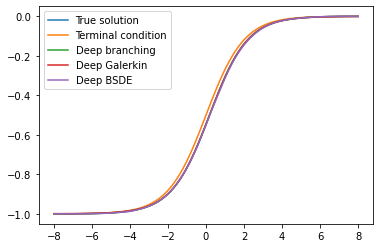

In [7]:
T = .125
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 6.17E-04; L2 error: 5.64E-07; rel error: 7.30E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 76 seconds; L1 error: 1.84E-03; L2 error: 3.92E-06; rel error: 4.02E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 1.79E-03; L2 error: 5.84E-06; rel error: 5.68E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 5.22E-04; L2 error: 4.06E-07; rel error: 5.89E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 70 seconds; L1 error: 5.55E-04; L2 error: 4.40E-07; rel error: 1.32E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 2.66E-03; L2 error: 1.14E-05; rel error: 4.75E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 7.64E-04; L2 error: 9.48E-07; rel error: 6.41E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 73 seconds; L1 error: 1.13E-03; L2 error: 2.00E-06; rel error: 3.65E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 3.42E-03; L2 error: 1.84E-05; rel error: 3.72E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 3.84E-04; L2 error: 2.24E-07; rel error: 2.55E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 72 seconds; L1 error: 1.12E-03; L2 error: 1.65E-06; rel error: 1.71E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 3.76E-03; L2 error: 2.58E-05; rel error: 2.89E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 5.01E-04; L2 error: 4.28E-07; rel error: 7.13E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 74 seconds; L1 error: 6.09E-03; L2 error: 4.39E-05; rel error: 8.35E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.89E-03; L2 error: 5.75E-06; rel error: 2.62E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 4.39E-04; L2 error: 3.19E-07; rel error: 4.86E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 72 seconds; L1 error: 5.07E-04; L2 error: 4.42E-07; rel error: 7.53E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 2.68E-03; L2 error: 1.45E-05; rel error: 5.42E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 5.70E-04; L2 error: 4.95E-07; rel error: 5.82E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 68 seconds; L1 error: 9.03E-04; L2 error: 1.55E-06; rel error: 2.87E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 4.14E-03; L2 error: 3.33E-05; rel error: 2.94E-01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 5.86E-04; L2 error: 6.02E-07; rel error: 1.78E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 69 seconds; L1 error: 6.84E-03; L2 error: 5.44E-05; rel error: 1.18E+00.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 2.48E-03; L2 error: 1.17E-05; rel error: 1.59E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 4.88E-04; L2 error: 3.64E-07; rel error: 5.46E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 76 seconds; L1 error: 1.74E-03; L2 error: 3.61E-06; rel error: 2.23E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 91 seconds; L1 error: 2.73E-03; L2 error: 9.51E-06; rel error: 5.52E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 5.06E-04; L2 error: 4.64E-07; rel error: 3.39E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 63 seconds; L1 error: 5.31E-03; L2 error: 3.11E-05; rel error: 9.56E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 90 seconds; L1 error: 4.46E-03; L2 error: 4.06E-05; rel error: 7.54E-01.




######## Summary for deep branching method
runtime:        38
fdb runtime:    0
total runtime:  38
mean L1 error:  5.38E-04
std L1 error:   9.98E-05
mean L2 error:  4.81E-07
std L2 error:   1.88E-07
mean rel error: 5.06E-02
std rel error:  1.80E-02


######## Summary for deep galerkin method
runtime:        71
mean L1 error:  2.60E-03
std L1 error:   2.34E-03
mean L2 error:  1.43E-05
std L2 error:   1.96E-05
mean rel error: 4.62E-01
std rel error:  3.66E-01


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  3.00E-03
std L1 error

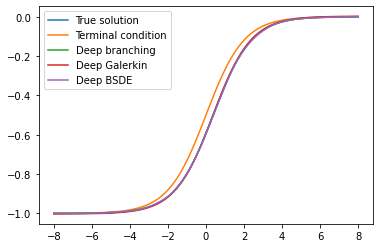

In [8]:
T = .25
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 7.99E-04; L2 error: 1.16E-06; rel error: 7.48E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 75 seconds; L1 error: 7.27E-04; L2 error: 7.84E-07; rel error: 1.20E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 2.26E-03; L2 error: 8.33E-06; rel error: 4.67E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 5.86E-04; L2 error: 5.61E-07; rel error: 3.03E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 64 seconds; L1 error: 4.08E-04; L2 error: 3.48E-07; rel error: 8.38E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 2.57E-03; L2 error: 9.97E-06; rel error: 2.38E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 8.89E-04; L2 error: 1.17E-06; rel error: 8.21E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 72 seconds; L1 error: 7.47E-04; L2 error: 8.45E-07; rel error: 1.92E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 2.29E-03; L2 error: 1.21E-05; rel error: 3.81E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 4.89E-04; L2 error: 3.58E-07; rel error: 2.69E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 65 seconds; L1 error: 6.31E-04; L2 error: 7.14E-07; rel error: 8.12E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 2.57E-03; L2 error: 1.23E-05; rel error: 2.61E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.10E-03; L2 error: 1.91E-06; rel error: 1.33E-01.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 83 seconds; L1 error: 4.41E-04; L2 error: 3.35E-07; rel error: 5.31E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 4.21E-03; L2 error: 3.43E-05; rel error: 1.83E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 3.56E-04; L2 error: 2.40E-07; rel error: 1.11E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 77 seconds; L1 error: 5.57E-04; L2 error: 3.85E-07; rel error: 5.34E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 2.94E-03; L2 error: 1.90E-05; rel error: 3.08E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 7.66E-04; L2 error: 9.57E-07; rel error: 5.38E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 74 seconds; L1 error: 1.42E-03; L2 error: 2.76E-06; rel error: 3.33E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 4.38E-03; L2 error: 4.77E-05; rel error: 4.82E-01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 8.78E-04; L2 error: 1.46E-06; rel error: 5.93E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 62 seconds; L1 error: 4.45E-04; L2 error: 2.85E-07; rel error: 7.57E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 2.37E-03; L2 error: 1.55E-05; rel error: 4.19E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 5.25E-04; L2 error: 4.16E-07; rel error: 5.05E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 77 seconds; L1 error: 5.10E-03; L2 error: 2.95E-05; rel error: 8.37E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 3.76E-03; L2 error: 2.45E-05; rel error: 7.35E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 7.69E-04; L2 error: 1.40E-06; rel error: 3.92E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 71 seconds; L1 error: 2.87E-03; L2 error: 9.39E-06; rel error: 4.69E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 81 seconds; L1 error: 6.22E-03; L2 error: 7.13E-05; rel error: 8.78E-01.




######## Summary for deep branching method
runtime:        39
fdb runtime:    0
total runtime:  39
mean L1 error:  7.16E-04
std L1 error:   2.13E-04
mean L2 error:  9.63E-07
std L2 error:   5.26E-07
mean rel error: 5.60E-02
std rel error:  3.28E-02


######## Summary for deep galerkin method
runtime:        72
mean L1 error:  1.33E-03
std L1 error:   1.44E-03
mean L2 error:  4.53E-06
std L2 error:   8.72E-06
mean rel error: 2.30E-01
std rel error:  2.41E-01


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  3.36E-03
std L1 error

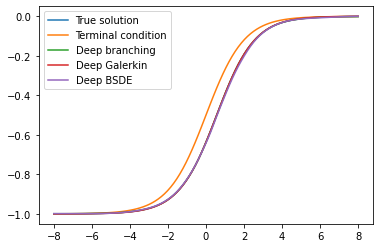

In [9]:
T = .375
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 1.27E-03; L2 error: 4.53E-06; rel error: 2.01E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 78 seconds; L1 error: 7.67E-04; L2 error: 1.17E-06; rel error: 2.24E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 3.20E-03; L2 error: 1.47E-05; rel error: 3.11E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 1.01E-03; L2 error: 2.67E-06; rel error: 3.88E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 66 seconds; L1 error: 6.40E-04; L2 error: 6.87E-07; rel error: 4.05E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 3.87E-03; L2 error: 2.09E-05; rel error: 4.44E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.12E-03; L2 error: 2.32E-06; rel error: 5.07E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 79 seconds; L1 error: 9.69E-04; L2 error: 1.09E-06; rel error: 7.52E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 4.57E-03; L2 error: 4.82E-05; rel error: 3.51E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 34 seconds; L1 error: 8.60E-04; L2 error: 1.65E-06; rel error: 1.75E-02.
fdb runtime: 0 seconds; total runtime: 34 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 71 seconds; L1 error: 9.19E-04; L2 error: 1.32E-06; rel error: 1.08E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 3.36E-03; L2 error: 1.73E-05; rel error: 5.72E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.26E-03; L2 error: 5.23E-06; rel error: 4.67E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 71 seconds; L1 error: 5.96E-04; L2 error: 6.02E-07; rel error: 8.03E-02.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 82 seconds; L1 error: 4.85E-03; L2 error: 4.07E-05; rel error: 4.11E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.07E-03; L2 error: 2.38E-06; rel error: 5.43E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 70 seconds; L1 error: 4.23E-04; L2 error: 2.84E-07; rel error: 4.88E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 4.73E-03; L2 error: 4.07E-05; rel error: 2.45E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 32 seconds; L1 error: 1.29E-03; L2 error: 3.64E-06; rel error: 5.78E-02.
fdb runtime: 0 seconds; total runtime: 32 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 65 seconds; L1 error: 1.44E-03; L2 error: 2.83E-06; rel error: 1.03E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 6.39E-03; L2 error: 7.88E-05; rel error: 1.17E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.12E-03; L2 error: 2.96E-06; rel error: 5.57E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 75 seconds; L1 error: 4.34E-04; L2 error: 2.82E-07; rel error: 4.37E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 4.55E-03; L2 error: 3.63E-05; rel error: 2.16E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 1.04E-03; L2 error: 2.09E-06; rel error: 3.84E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 78 seconds; L1 error: 5.82E-04; L2 error: 7.80E-07; rel error: 1.36E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 4.38E-03; L2 error: 3.11E-05; rel error: 3.43E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 1.31E-03; L2 error: 4.66E-06; rel error: 2.32E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 71 seconds; L1 error: 5.35E-04; L2 error: 5.88E-07; rel error: 9.87E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 85 seconds; L1 error: 6.06E-03; L2 error: 7.68E-05; rel error: 2.90E-01.




######## Summary for deep branching method
runtime:        37
fdb runtime:    0
total runtime:  37
mean L1 error:  1.14E-03
std L1 error:   1.40E-04
mean L2 error:  3.21E-06
std L2 error:   1.17E-06
mean rel error: 4.03E-02
std rel error:  1.45E-02


######## Summary for deep galerkin method
runtime:        72
mean L1 error:  7.30E-04
std L1 error:   2.94E-04
mean L2 error:  9.64E-07
std L2 error:   7.05E-07
mean rel error: 9.59E-02
std rel error:  5.20E-02


######## Summary for deep BSDE method
runtime:        88
mean L1 error:  4.60E-03
std L1 error

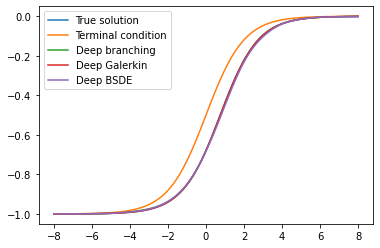

In [10]:
T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 42 seconds; L1 error: 2.64E-03; L2 error: 1.82E-05; rel error: 1.09E-02.
fdb runtime: 0 seconds; total runtime: 42 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 73 seconds; L1 error: 1.24E-03; L2 error: 3.66E-06; rel error: 2.17E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 5.72E-03; L2 error: 5.44E-05; rel error: 5.27E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 2.13E-03; L2 error: 1.29E-05; rel error: 2.37E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 74 seconds; L1 error: 6.51E-04; L2 error: 7.87E-07; rel error: 6.06E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 4.16E-03; L2 error: 4.15E-05; rel error: 3.25E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 2.06E-03; L2 error: 1.04E-05; rel error: 2.91E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 65 seconds; L1 error: 5.97E-04; L2 error: 8.43E-07; rel error: 1.62E-01.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 85 seconds; L1 error: 6.98E-03; L2 error: 8.86E-05; rel error: 8.63E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.73E-03; L2 error: 7.47E-06; rel error: 3.44E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 76 seconds; L1 error: 1.49E-03; L2 error: 3.06E-06; rel error: 1.40E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 4.76E-03; L2 error: 3.86E-05; rel error: 3.73E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 2.36E-03; L2 error: 1.38E-05; rel error: 6.47E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 78 seconds; L1 error: 2.24E-03; L2 error: 7.49E-06; rel error: 2.31E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 6.44E-03; L2 error: 8.09E-05; rel error: 3.36E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.91E-03; L2 error: 1.02E-05; rel error: 1.95E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 77 seconds; L1 error: 1.43E-03; L2 error: 2.45E-06; rel error: 1.25E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 6.15E-03; L2 error: 8.41E-05; rel error: 1.73E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 2.53E-03; L2 error: 1.57E-05; rel error: 1.10E-01.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 66 seconds; L1 error: 1.35E-03; L2 error: 2.20E-06; rel error: 1.15E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 8.03E-03; L2 error: 1.35E-04; rel error: 1.06E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 2.26E-03; L2 error: 1.16E-05; rel error: 3.69E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 62 seconds; L1 error: 2.36E-03; L2 error: 6.19E-06; rel error: 2.66E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 82 seconds; L1 error: 4.96E-03; L2 error: 5.94E-05; rel error: 2.17E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 1.96E-03; L2 error: 8.92E-06; rel error: 2.31E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 77 seconds; L1 error: 1.04E-03; L2 error: 1.97E-06; rel error: 2.37E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 5.91E-03; L2 error: 6.66E-05; rel error: 3.27E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 3.00E-03; L2 error: 1.98E-05; rel error: 2.57E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 76 seconds; L1 error: 1.77E-03; L2 error: 4.37E-06; rel error: 5.55E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 91 seconds; L1 error: 7.45E-03; L2 error: 1.13E-04; rel error: 5.70E-01.




######## Summary for deep branching method
runtime:        39
fdb runtime:    0
total runtime:  39
mean L1 error:  2.26E-03
std L1 error:   3.63E-04
mean L2 error:  1.29E-05
std L2 error:   3.81E-06
mean rel error: 3.78E-02
std rel error:  2.78E-02


######## Summary for deep galerkin method
runtime:        73
mean L1 error:  1.42E-03
std L1 error:   5.59E-04
mean L2 error:  3.30E-06
std L2 error:   2.08E-06
mean rel error: 1.61E-01
std rel error:  7.07E-02


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  6.06E-03
std L1 error

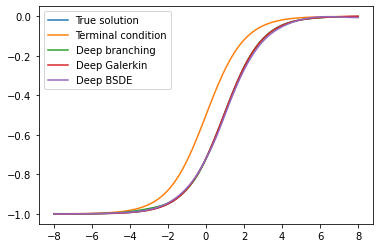

In [11]:
T = .625
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 5.18E-03; L2 error: 8.44E-05; rel error: 1.45E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 76 seconds; L1 error: 1.52E-03; L2 error: 6.36E-06; rel error: 2.63E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 5.84E-03; L2 error: 6.24E-05; rel error: 6.55E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 4.49E-03; L2 error: 4.86E-05; rel error: 6.56E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 71 seconds; L1 error: 7.42E-04; L2 error: 1.21E-06; rel error: 1.12E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 9.17E-03; L2 error: 1.51E-04; rel error: 1.05E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 5.12E-03; L2 error: 6.43E-05; rel error: 2.83E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 74 seconds; L1 error: 1.18E-03; L2 error: 1.80E-06; rel error: 1.69E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 8.05E-03; L2 error: 1.15E-04; rel error: 5.37E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 4.59E-03; L2 error: 5.37E-05; rel error: 3.62E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 64 seconds; L1 error: 5.19E-04; L2 error: 6.40E-07; rel error: 7.45E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 7.72E-03; L2 error: 1.05E-04; rel error: 4.14E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 4.51E-03; L2 error: 5.20E-05; rel error: 4.84E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 73 seconds; L1 error: 1.27E-03; L2 error: 3.50E-06; rel error: 1.34E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 9.68E-03; L2 error: 1.61E-04; rel error: 5.66E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 28 seconds; L1 error: 4.30E-03; L2 error: 5.11E-05; rel error: 1.84E-02.
fdb runtime: 0 seconds; total runtime: 28 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 60 seconds; L1 error: 1.06E-03; L2 error: 1.63E-06; rel error: 7.66E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 86 seconds; L1 error: 9.45E-03; L2 error: 1.88E-04; rel error: 2.68E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 5.03E-03; L2 error: 6.75E-05; rel error: 6.90E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 67 seconds; L1 error: 1.04E-03; L2 error: 1.90E-06; rel error: 1.63E-01.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 8.63E-03; L2 error: 1.88E-04; rel error: 4.65E-01.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 5.11E-03; L2 error: 6.44E-05; rel error: 2.83E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 79 seconds; L1 error: 5.60E-03; L2 error: 3.67E-05; rel error: 4.16E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 9.63E-03; L2 error: 1.80E-04; rel error: 1.15E+00.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 4.59E-03; L2 error: 4.90E-05; rel error: 3.01E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 76 seconds; L1 error: 4.71E-03; L2 error: 2.74E-05; rel error: 5.68E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 8.16E-03; L2 error: 1.10E-04; rel error: 6.20E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 5.90E-03; L2 error: 9.00E-05; rel error: 2.87E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 79 seconds; L1 error: 9.37E-04; L2 error: 1.80E-06; rel error: 1.65E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 90 seconds; L1 error: 9.74E-03; L2 error: 1.72E-04; rel error: 4.16E-01.




######## Summary for deep branching method
runtime:        37
fdb runtime:    0
total runtime:  37
mean L1 error:  4.88E-03
std L1 error:   4.54E-04
mean L2 error:  6.25E-05
std L2 error:   1.40E-05
mean rel error: 3.67E-02
std rel error:  1.76E-02


######## Summary for deep galerkin method
runtime:        72
mean L1 error:  1.86E-03
std L1 error:   1.68E-03
mean L2 error:  8.30E-06
std L2 error:   1.22E-05
mean rel error: 1.99E-01
std rel error:  1.63E-01


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  8.61E-03
std L1 error

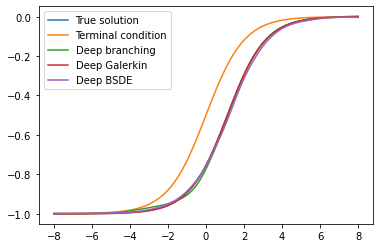

In [12]:
T = .75
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 8.63E-03; L2 error: 2.12E-04; rel error: 4.58E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 70 seconds; L1 error: 1.99E-03; L2 error: 1.11E-05; rel error: 2.58E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 81 seconds; L1 error: 8.22E-03; L2 error: 1.68E-04; rel error: 4.16E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 7.72E-03; L2 error: 1.74E-04; rel error: 2.14E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 63 seconds; L1 error: 1.09E-03; L2 error: 2.50E-06; rel error: 1.06E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 8.17E-03; L2 error: 1.56E-04; rel error: 2.70E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 35 seconds; L1 error: 8.63E-03; L2 error: 1.88E-04; rel error: 2.92E-02.
fdb runtime: 0 seconds; total runtime: 35 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 71 seconds; L1 error: 5.48E-04; L2 error: 5.74E-07; rel error: 7.83E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 85 seconds; L1 error: 1.18E-02; L2 error: 2.80E-04; rel error: 7.64E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 7.69E-03; L2 error: 1.49E-04; rel error: 4.23E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 64 seconds; L1 error: 7.92E-04; L2 error: 1.01E-06; rel error: 1.06E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.13E-02; L2 error: 2.24E-04; rel error: 1.09E+00.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 7.96E-03; L2 error: 1.55E-04; rel error: 3.55E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 81 seconds; L1 error: 2.39E-03; L2 error: 7.94E-06; rel error: 2.07E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 9.10E-03; L2 error: 2.04E-04; rel error: 1.95E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 35 seconds; L1 error: 8.55E-03; L2 error: 1.90E-04; rel error: 4.74E-02.
fdb runtime: 0 seconds; total runtime: 35 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 73 seconds; L1 error: 1.02E-03; L2 error: 1.39E-06; rel error: 8.24E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 1.27E-02; L2 error: 2.98E-04; rel error: 6.70E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 8.51E-03; L2 error: 1.92E-04; rel error: 2.96E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 80 seconds; L1 error: 1.99E-03; L2 error: 4.74E-06; rel error: 5.67E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 91 seconds; L1 error: 1.48E-02; L2 error: 5.16E-04; rel error: 1.07E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 41 seconds; L1 error: 8.66E-03; L2 error: 1.89E-04; rel error: 4.37E-02.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 75 seconds; L1 error: 6.99E-04; L2 error: 7.90E-07; rel error: 6.22E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 9.24E-03; L2 error: 1.95E-04; rel error: 3.99E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 8.33E-03; L2 error: 1.66E-04; rel error: 3.38E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 71 seconds; L1 error: 1.00E-03; L2 error: 2.35E-06; rel error: 1.71E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 83 seconds; L1 error: 1.07E-02; L2 error: 1.72E-04; rel error: 5.07E-01.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 8.75E-03; L2 error: 1.86E-04; rel error: 2.28E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 84 seconds; L1 error: 1.80E-03; L2 error: 4.89E-06; rel error: 2.47E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 90 seconds; L1 error: 1.23E-02; L2 error: 3.00E-04; rel error: 4.87E-01.




######## Summary for deep branching method
runtime:        38
fdb runtime:    0
total runtime:  38
mean L1 error:  8.34E-03
std L1 error:   3.82E-04
mean L2 error:  1.80E-04
std L2 error:   1.82E-05
mean rel error: 3.51E-02
std rel error:  8.94E-03


######## Summary for deep galerkin method
runtime:        73
mean L1 error:  1.33E-03
std L1 error:   6.14E-04
mean L2 error:  3.73E-06
std L2 error:   3.30E-06
mean rel error: 1.38E-01
std rel error:  7.30E-02


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  1.08E-02
std L1 error

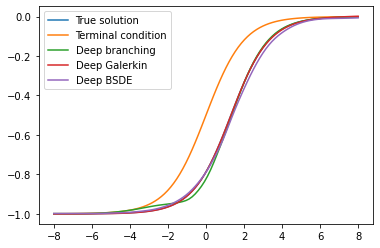

In [13]:
T = .875
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 1.30E-02; L2 error: 4.52E-04; rel error: 3.26E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 74 seconds; L1 error: 2.60E-03; L2 error: 1.75E-05; rel error: 2.38E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 90 seconds; L1 error: 1.42E-02; L2 error: 4.10E-04; rel error: 1.02E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.14E-02; L2 error: 3.57E-04; rel error: 2.87E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 70 seconds; L1 error: 1.30E-03; L2 error: 4.56E-06; rel error: 1.52E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 84 seconds; L1 error: 1.09E-02; L2 error: 2.94E-04; rel error: 6.37E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 39 seconds; L1 error: 1.28E-02; L2 error: 3.86E-04; rel error: 4.38E-02.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 76 seconds; L1 error: 7.03E-04; L2 error: 1.09E-06; rel error: 4.90E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 88 seconds; L1 error: 9.97E-03; L2 error: 2.48E-04; rel error: 2.66E-01.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 37 seconds; L1 error: 1.19E-02; L2 error: 3.44E-04; rel error: 3.49E-02.
fdb runtime: 0 seconds; total runtime: 37 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 76 seconds; L1 error: 1.08E-03; L2 error: 2.53E-06; rel error: 1.26E-01.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 1.49E-02; L2 error: 4.61E-04; rel error: 6.38E-01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 1.21E-02; L2 error: 3.42E-04; rel error: 4.31E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 64 seconds; L1 error: 4.20E-03; L2 error: 2.27E-05; rel error: 3.08E-01.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 82 seconds; L1 error: 1.48E-02; L2 error: 6.28E-04; rel error: 3.05E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 34 seconds; L1 error: 1.31E-02; L2 error: 4.43E-04; rel error: 6.19E-02.
fdb runtime: 0 seconds; total runtime: 34 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 63 seconds; L1 error: 1.60E-03; L2 error: 3.40E-06; rel error: 1.22E-01.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 89 seconds; L1 error: 1.47E-02; L2 error: 4.66E-04; rel error: 2.60E-01.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 1.26E-02; L2 error: 3.82E-04; rel error: 3.38E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 69 seconds; L1 error: 1.36E-03; L2 error: 2.33E-06; rel error: 6.39E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 1.67E-02; L2 error: 7.06E-04; rel error: 1.10E+00.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 40 seconds; L1 error: 1.24E-02; L2 error: 3.75E-04; rel error: 2.94E-02.
fdb runtime: 0 seconds; total runtime: 40 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 74 seconds; L1 error: 6.17E-03; L2 error: 4.54E-05; rel error: 3.42E-01.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 87 seconds; L1 error: 1.21E-02; L2 error: 3.99E-04; rel error: 2.23E-01.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 36 seconds; L1 error: 1.28E-02; L2 error: 3.93E-04; rel error: 4.68E-02.
fdb runtime: 0 seconds; total runtime: 36 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 72 seconds; L1 error: 4.96E-03; L2 error: 3.16E-05; rel error: 4.45E-01.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 91 seconds; L1 error: 1.53E-02; L2 error: 4.93E-04; rel error: 1.12E+00.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 38 seconds; L1 error: 1.36E-02; L2 error: 4.48E-04; rel error: 3.57E-02.
fdb runtime: 0 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 79 seconds; L1 error: 2.72E-03; L2 error: 1.10E-05; rel error: 3.02E-01.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 81 seconds; L1 error: 1.81E-02; L2 error: 5.71E-04; rel error: 6.11E-01.




######## Summary for deep branching method
runtime:        37
fdb runtime:    0
total runtime:  37
mean L1 error:  1.26E-02
std L1 error:   6.21E-04
mean L2 error:  3.92E-04
std L2 error:   3.98E-05
mean rel error: 3.91E-02
std rel error:  9.59E-03


######## Summary for deep galerkin method
runtime:        72
mean L1 error:  2.67E-03
std L1 error:   1.76E-03
mean L2 error:  1.42E-05
std L2 error:   1.42E-05
mean rel error: 2.15E-01
std rel error:  1.25E-01


######## Summary for deep BSDE method
runtime:        87
mean L1 error:  1.42E-02
std L1 error

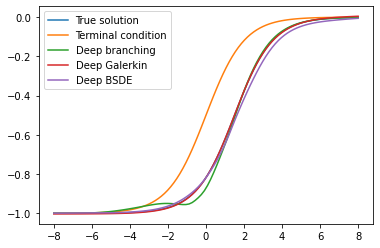

In [14]:
T = 1.00
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)